#### This notebook shows how to apply GRAPPA algorithm as a preprocessing step prior to feeding the subsampled images to a neural network.

In [1]:
# Testing if integration works

In [2]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

from data import transforms as T
from common.subsample import RandomMaskFunc
from common.utils import tensor_to_complex_np
from pygrappa import grappa

As usual, we start by loading a file from the knee multi-coil dataset and extracting s k-space slice from the volume, as described in the notebook 'fastMRI_tutorial'.

In [3]:
file_name = 'dataset/knee/file1001465.h5'
hf = h5py.File(file_name)

In [4]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume
print(slice_kspace.dtype)
print(slice_kspace.shape)

complex64
(15, 640, 322)


Let's define some helper functions for plotting the coil images.

In [5]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [6]:
def kspace_to_image(slice_kspace):
    """
    Transfroms kspace data to real-valued image.
    Args:
        slice_kspace (numpy.array): Multi-coil input k-space of shape (num_coils, rows, cols) 
    Returns:
        image: (numpy.array): Multi-channel image of shape (num_coils, rows, cols)
    """
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = T.ifft2(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = T.complex_abs(slice_image)   # Compute absolute value to get a real image
    return slice_image_abs

Let's see what the absolute value of the full sampled k-space looks like:

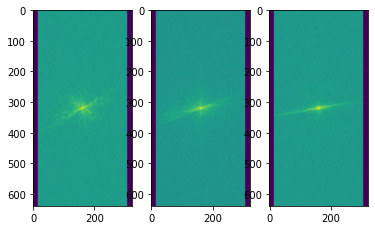

In [7]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

And the corresponding coil images:

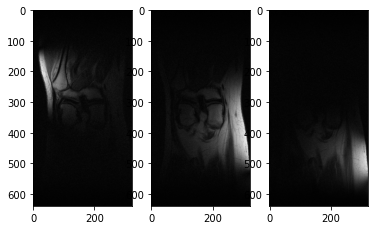

In [8]:
show_coils(kspace_to_image(slice_kspace), [0, 5, 10], cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [9]:
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[4])  # Create the mask function object

In [10]:
masked_kspace, mask = T.apply_mask(T.to_tensor(slice_kspace), mask_func)   # Apply the mask to k-space

Let's see what the absolute value of the subsampled k-space looks like:

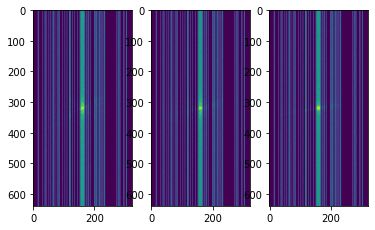

In [11]:
show_coils(np.log(np.abs(tensor_to_complex_np(masked_kspace)) + 1e-9), [0, 5, 10])

And the subsampled coil images:

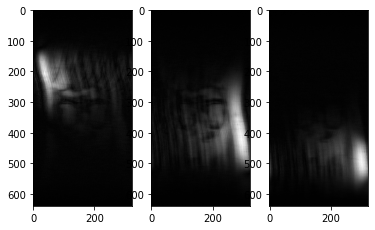

In [12]:
show_coils(kspace_to_image(tensor_to_complex_np(masked_kspace)), [0, 5, 10], cmap='gray')

Now the interesting part starts. We will apply GRAPPA algorithm to the subsampled data, in order to try to reconstruct the original fully sampled data. Applying this preprocessing step befor passing the subsampled images through a neural network would help increase its performance by a significant amount.

The 'grappa' function we use takes in two arguments: the 2D multi-coil k-space data to reconstruct from, where the missing (undersampled) entries have exact zeros in them and calibration data which corresponds to fully-sampled k-space data. To get this calibration data, we use the central region of k-space corresponding to low frequen- cies, called the Auto-Calibration Signal (ACS), which is typically fully sampled.

In [13]:
def apply_grappa(masked_kspace, mask):
    """
    Applies GRAPPA algorithm
    References
    ----------
    [1] Griswold, Mark A., et al. "Generalized autocalibrating
       partially parallel acquisitions (GRAPPA)." Magnetic
       Resonance in Medicine: An Official Journal of the
       International Society for Magnetic Resonance in Medicine
       47.6 (2002): 1202-1210.
    Args:
        masked_kspace (torch.Tensor): Multi-coil masked input k-space of shape (num_coils, rows, cols, 2)
        mask (torch.Tensor): Applied mask of shape (1, 1, cols, 1)
    Returns:
        preprocessed_masked_kspace (torch.Tensor): Output of GRAPPA algorithm applied on masked_kspace
    """

    def get_low_frequency_lines(mask):
        l = r = mask.shape[-2] // 2
        while mask[..., r, :]:
            r += 1

        while mask[..., l, :]:
            l -= 1

        return l + 1, r

    l, r = get_low_frequency_lines(mask)
    num_low_freqs = r - l
    pad = (mask.shape[-2] - num_low_freqs + 1) // 2
    calib = masked_kspace[:, :, pad:pad + num_low_freqs].clone()
    preprocessed_masked_kspace = grappa(tensor_to_complex_np(masked_kspace), tensor_to_complex_np(calib), kernel_size=(5, 5), coil_axis=0)
    return T.to_tensor(preprocessed_masked_kspace)

In [14]:
grappa_kspace = apply_grappa(masked_kspace, mask)

Let's look at the preprocessed k-space data with GRAPPA

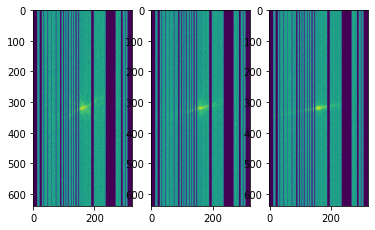

In [15]:
show_coils(np.log(np.abs(tensor_to_complex_np(grappa_kspace)) + 1e-9), [0, 5, 10])

Notice that the dark blue regions, which correspond to missing values is a lot smaller compared to the unprocessed masked k-space data, becuase most of these values have been filled in with GRAPPA.

Finally, let's look at the corresponding multi-coil images.

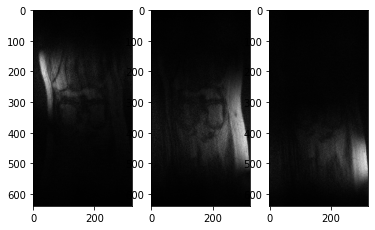

In [16]:
show_coils(kspace_to_image(tensor_to_complex_np(grappa_kspace)), [0, 5, 10], cmap='gray')

As you can see, these images look much more clear than those corresponding to the unprocessed masked k-space, which would help the neural network model during its training process.